## Classifying a phase transition in the XXZ model

In [1]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import qiskit.extensions.quantum_initializer as qeqi
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
from skopt import gp_minimize
from numba import jit, njit
from copy import copy, deepcopy

import sys
sys.path.append("..")

import Entangler
import TensorNetwork
import hamiltonians
import TNOptimize
import uuid
import json
import utils

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

In [3]:
n_qubits = 10
depth = 4
depth_classifier = 6
q, c = QuantumRegister(n_qubits), ClassicalRegister(n_qubits)
ent = Entangler.IsingEntangler()
TN = TensorNetwork.Checkerboard(q, c, ent, depth=depth)
# TN_UCC = TensorNetwork.UCCSD(q, c)
TN_classifier = TensorNetwork.Checkerboard(q, c, ent, depth=depth_classifier)


tol = 1e-6
method = "L-BFGS-B"
n_max = 2**n_qubits + 100
n_cdata = 2**n_qubits
sv_b = Aer.get_backend("statevector_simulator")
qasm_b = Aer.get_backend("qasm_simulator")
unitary_b = Aer.get_backend('unitary_simulator')

### Loading the data

The data set contains the rows where first 1024 entries are the wavefunction, next 100 are the parameters, then the Jz parameter, energy, and label

In [5]:
import pandas as pd
import numpy as np

# Assuming filenames and n_max are defined as before
small_data = "vqe_2024-02-17_17-27-47.csv"
bigger_data = "vqe_2024-02-17_17-27-47.csv"
gpu_data = "vqe_2024-02-17_17-27-47.csv"
filename = bigger_data

# Assuming n_max is defined somewhere in your code
# n_max = ...

df_vqe_2 = pd.read_csv(filename, header=None)
# Use complex (the built-in type) directly
df_vqe_2 = df_vqe_2.applymap(lambda x: complex(x))

# Converting specific columns to real, assuming n_max is properly defined
df_vqe_2[n_max] = df_vqe_2[n_max].apply(lambda x: x.real)
df_vqe_2[n_max+1] = df_vqe_2[n_max+1].apply(lambda x: x.real)
df_vqe_2[n_max+2] = df_vqe_2[n_max+2].apply(lambda x: x.real)

# If df_vqe_2.drop([0, 1]) was intended to remove the first two rows, use:
# df_vqe = df_vqe_2.drop([0, 1], axis=0)
# If it was intended to remove the first two columns, use:
# df_vqe = df_vqe_2.drop([0, 1], axis=1)

# If no rows or columns were meant to be dropped based on the commented line,
# just assign df_vqe_2 to df_vqe
df_vqe = df_vqe_2


### Cleaning the data

In [6]:
df_vqe_clean = df_vqe.sort_values(by=[n_max])
df_vqe_clean.index = np.arange(len(df_vqe))
# df_vqe_clean = df_vqe.sort_index(by=[n_max])

todrop = []
tokeep = []
for i in range(len(df_vqe) // 2):
    E_1 = df_vqe_clean.iloc[i * 2, n_max + 1]
    E_2 = df_vqe_clean.iloc[i * 2 + 1, n_max + 1]
    h_1 = df_vqe_clean.iloc[i * 2, n_max]
    h_2 = df_vqe_clean.iloc[i * 2 + 1, n_max]
#     print(h_1, h_2)
#     print(E_1, E_2)
#     print("====")
    if (E_2 > E_1):
        todrop.append(i * 2 + 1)
        tokeep.append(i * 2)
    else:
        todrop.append(i * 2)
        tokeep.append(i * 2 + 1)

        
for i in range(len(df_vqe) // 2):
    E_kept = df_vqe_clean.iloc[tokeep[i], n_max + 1]
    E_dropped = df_vqe_clean.iloc[todrop[i], n_max + 1]
    if E_dropped < E_kept:
        print("AAA")

print(df_vqe_clean.iloc[:20, [n_max, n_max + 1]])

print(todrop[:10])
print(tokeep[:10])

print("=============")        
        
df_vqe_clean = df_vqe_clean.drop(todrop)
print(df_vqe_clean.iloc[:10, [n_max, n_max + 1]])

     1124       1125
0   0.000 -12.446647
1   0.000 -12.436976
2   0.002 -12.444494
3   0.002 -12.461848
4   0.004 -12.469379
5   0.004 -12.452020
6   0.006 -12.476913
7   0.006 -12.459552
8   0.008 -12.467089
9   0.008 -12.484449
10  0.010 -12.474632
11  0.010 -12.491989
12  0.012 -12.482181
13  0.012 -12.499533
14  0.014 -12.489733
15  0.014 -12.507081
16  0.016 -12.497290
17  0.016 -12.514633
18  0.018 -12.522189
19  0.018 -12.504719
[1, 2, 5, 7, 8, 10, 12, 14, 16, 19]
[0, 3, 4, 6, 9, 11, 13, 15, 17, 18]
     1124       1125
0   0.000 -12.446647
3   0.002 -12.461848
4   0.004 -12.469379
6   0.006 -12.476913
9   0.008 -12.484449
11  0.010 -12.491989
13  0.012 -12.499533
15  0.014 -12.507081
17  0.016 -12.514633
18  0.018 -12.522189


In [7]:
len(df_vqe_clean)

1000

### Augmenting the data

#### Flips

First I am going to flip the spins along the X direction. Then for each of the data points I will also add a random Z rotation.

In [8]:
df_flip = df_vqe_clean.copy()
# df_flip = df_vqe.copy()
df_flip.index = np.arange(len(df_flip))


In [9]:
## hardcoded for 10 qubits and depth 4
z_gate_indices = [74 + i * 5 + k for i in range(5) for k in (4, 5)]
x_gate_indices = [74 + i * 5 + k for i in range(5) for k in (1, 2)]

In [10]:
for n in z_gate_indices:
    df_flip[2**n_qubits + n] *= -1

for n in x_gate_indices:
    df_flip[2**n_qubits + n] += np.pi

In [11]:
wavefun_cols_order = list(reversed(range(1024)))
cols_order = wavefun_cols_order + list(range(1024, n_max + 3))
df_flip = df_flip.reindex(columns=cols_order)

To check the correctness of the flip operation, I will now check that the wavefunction, ansatz parameters and the energy are consistent

In [14]:
# Initialize Hamiltonians
h_0 = hamiltonians.xxz_heisenberg_model(10, 1, 0)
h_1 = hamiltonians.xxz_heisenberg_model(10, 0, 1)
H_0 = hamiltonians.explicit_hamiltonian(h_0)
H_1 = hamiltonians.explicit_hamiltonian(h_1)

energy_off = False
statebuilding_error = False

for i, row in df_flip.iterrows():
    # Extract state and energy information
    state = np.array(row[:2**n_qubits], dtype=np.complex128)
    E = row[n_max + 1].real
    h = row[n_max].real
    
    # Calculate the expected energy
    E_fact = (state.conj().T @ (H_0 + h * H_1) @ state).real.item()
    
    if not np.isclose(E, E_fact):
        print(f"Found energy error in row {i}")
        energy_off = True
    
    # Build the quantum circuit and retrieve the state
    params = np.array(row[2**n_qubits : 2**n_qubits + 100], dtype=np.float64)  
    circ = TN.construct_circuit(params)
    state_built = utils.get_state(circ)
    
    # Check for state-building accuracy
    product = abs(state_built.conj().T @ state).item()
    if not np.isclose(product, 1):
        print(f"Found state vs params error in row {i}")
        statebuilding_error = True

if not energy_off and not statebuilding_error:
    print("All OK")

C:\Users\Louis\AppData\Roaming\Python\Python311\site-packages\pandas\core\series.py:917: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.asarray(values, dtype=dtype)
C:\Users\Louis\AppData\Local\Temp\ipykernel_3332\1080335451.py:29: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  product = abs(state_built.conj().T @ state).item()


All OK


In [16]:
print(isinstance(df_vqe, pd.DataFrame))
print(isinstance(df_flip, pd.DataFrame))

True
True


In [17]:
# Assuming df_vqe and df_flip are both pandas DataFrame objects
df_with_flip = pd.concat([df_vqe, df_flip], ignore_index=True)

# Now, get the length of the resulting DataFrame
length_of_df_with_flip = len(df_with_flip)

print(length_of_df_with_flip)

3000


#### Angles

In [18]:
df_rotated = df_with_flip.copy()
df_rotated.index = np.arange(len(df_rotated))


In [19]:
### change the params by adding random angles to params

for i in range(len(df_rotated)):
    angle = 2 * np.pi * np.random.rand()
    for n in z_gate_indices:
        df_rotated.iloc[i, 2**n_qubits + n] += angle

In [22]:
import numpy as np
from qiskit.quantum_info import Statevector

for i in range(len(df_rotated)):
    params_real = np.real(np.array(df_rotated.iloc[i, 2**n_qubits:(2**n_qubits + TN.n_params)]))
    circ = TN.construct_circuit(params_real)
    state_built = utils.get_state(circ)
    
    # Ensure state_built is a numpy array for matrix operations
    if isinstance(state_built, Statevector):
        state_built = state_built.data  # Convert Statevector to numpy array

    h = df_rotated.iloc[i, n_max].real
    # Assuming H_0 and H_1 are numpy arrays; adjust Hamiltonian calculation as needed
    H = H_0 + h * H_1
    
    # Ensure the Hamiltonian (H) and state_built are compatible for matrix multiplication
    E_built = np.real((state_built.conj().T @ H @ state_built).item())

    E = df_rotated.iloc[i, n_max + 1].real
    if not (np.isclose(E, E_built)):
        print('Energy discrepancy detected at index {}'.format(i))

    # Update DataFrame with the new state
    df_rotated.iloc[i, :2**n_qubits] = state_built.flatten()


In [15]:
# i = 150
# params = np.array(df_rotated.iloc[i, 2**n_qubits:(2**n_qubits + TN.n_params)])
# circ = TN.construct_circuit(params)
# state_built = utils.get_state(circ)
# E = df_rotated.iloc[i, n_max + 1]
# print(E)
# h = df_rotated.iloc[i, n_max]
# E_built = (state_built.conj() @ (H_0 + h * H_1) @ state_built).real
# print(E_built)
# state = np.array(df_rotated.iloc[i, :2**n_qubits])

In [24]:
df_total = pd.concat([df_with_flip, df_rotated], ignore_index=True)
df_total.index = np.arange(len(df_total))

In [25]:
#### Save the total database just in case
df_total.to_csv(path_or_buf="df_total_bigger.csv", index=False, header=None)

In [26]:
df = df_total.copy()
len(df_total)

6000

### Reload the prepared dataset if you don't want to build it

In [28]:
### Load if necessary

df_total = pd.read_csv("df_total_bigger.csv", header=None)
print(len(df_total))

# Use the built-in complex type for conversion
df_total = df_total.applymap(lambda x: complex(x))

# Ensure real parts are used where necessary
df_total[n_max] = df_total[n_max].apply(lambda x: x.real)
df_total[n_max+1] = df_total[n_max+1].apply(lambda x: x.real)


6000


### Split the data into train and test

In [29]:
df_shuffled = df_total.sample(frac=1).reset_index(drop=True)
train_pos = int(0.8 * len(df_total))
df_train = df_shuffled.iloc[:train_pos,:]
df_test = df_shuffled.iloc[train_pos:,:]

### Constructing objective functions

In [30]:
def count_ones(x):
    count = 0
    x_c = copy(x)
    while x_c != 0:
        x_c = x_c & (x_c-1)
        count += 1
    return count


# @jit
def unitary_prediction(state, U):
    """Returns the probability that the state is in class II by
    transforming the circuit into a unitary map"""
#     if U_supply is None:
#         result = execute(NN_circ, unitary_b).result()
#         U = result.get_unitary(NN_circ)
#     else:
#         U = U_supply
    res_state = U @ state
    
    label = [0, 0]
    
    for i in range(len(res_state)):
        qty_ones = count_ones(i)
        if qty_ones > n_qubits // 2:
            label[1] += abs(res_state[i])**2
        elif qty_ones < n_qubits // 2:
            label[0] += abs(res_state[i])**2 / 2 

    return label[1] / (label[0] + label[1])

def build_loss_fun(df, start, batch_size, TN_classifier):
    """construct the loss function for a batch"""
#     if (finish <= start):
#         raise ValueError("Specify other rows")
    if batch_size < 1:
        raise ValueError("Invalid batch size")
    #indices = np.random.choice(len(df), batch_size, replace=False)
    #indices = np.arange(start, start + batch_size)
    

    def f(x):
        circ = TN_classifier.construct_circuit(x)
        result = execute(circ, unitary_b).result()
        U = result.get_unitary(circ)
        logloss = 0
        for i in range(start, start+batch_size):
            state = np.array(df_train.iloc[i][:n_cdata])
            y = df_train.iloc[i][n_max+2].real
            p = unitary_prediction(state, U)
            logloss += -(y * np.log(p) + (1 - y) * np.log(1 - p))
            
        return logloss / batch_size
    return f

# @jit
def rand_grad(x, f, eps):
    dx = np.random.randn(np.shape(x)[0]) * eps
    f_plus = f(x + dx)
    f_minus = f(x - dx)
    return (f_plus - f_minus) / 2 / dx, 0.5 * (f_plus + f_minus)

In [31]:
count_ones(71)

4

### Running the machine learning

In [32]:
len(df_train)

4800

In [35]:
### Test ###
def unitary_prediction(state, U):
    # Perform matrix multiplication
    res_state = U @ state
    
    # Convert Qiskit's Statevector or Operator to a numpy array if not already
    if hasattr(res_state, 'data'):
        res_state = res_state.data
    elif not isinstance(res_state, np.ndarray):
        res_state = np.array(res_state)

    label = [0, 0]
    n_qubits = int(np.log2(len(res_state)))  # Calculate the number of qubits based on state vector length

    for i in range(len(res_state)):
        qty_ones = bin(i).count('1')  # Count the number of '1's in the binary representation of i
        if qty_ones > n_qubits // 2:
            label[1] += np.abs(res_state[i])**2  # Add the probability (amplitude squared) to '1' label
        else:
            label[0] += np.abs(res_state[i])**2  # Add the probability (amplitude squared) to '0' label

    # Assuming the prediction 'p' should be based on the probability of '1'
    p = label[1]  # Probability of measuring a state with more than half of the qubits in '1'
    return p


In [36]:
%%time
batch_size = 1600
n_epochs = 300

losses = []

# Assuming TN_classifier and build_loss_fun are defined
# Ensure TN_classifier.n_params is correctly defined
params = np.random.rand(TN_classifier.n_params) - 0.5
x = params

lr_base = 5
decay = 1e-3
factor = 1 - decay
eps_base = 5e-2

v = np.zeros(TN_classifier.n_params)  # Initialize momentum vector

for epoch in range(n_epochs):
    df_train = df_train.sample(frac=1).reset_index(drop=True)  # Shuffle the training set
    for batch_num in range(len(df_train) // batch_size):
        start = batch_size * batch_num
        f = build_loss_fun(df_train, start, batch_size, TN_classifier)  # Loss function for the current batch
        
        eps = eps_base / (1 + batch_num * (epoch + 1))**0.5
        lr = lr_base / (1 + batch_num * (epoch + 1))**0.5
        
        # Calculate gradient approximation
        dx = np.random.randn(np.shape(x)[0]) * eps  # Perturbation for finite difference
        f_plus = f(x + dx)
        f_minus = f(x - dx)
        
        # Corrected gradient calculation
        grad = (f_plus - f_minus) / (2 * eps)
        
        # Update momentum and parameters
        v = 0.9 * v - lr * grad
        x = x + v
        
        # Compute average loss for logging
        loss = (f_plus + f_minus) / 2
        if epoch % 20 == 0 or epoch < 15:
            print(f'Epoch {epoch} batch {batch_num}')
            print('loss:', loss)
        losses.append(loss)

Epoch 0 batch 0
loss: 0.8078886550570679
Epoch 0 batch 1
loss: 0.7561173059911166
Epoch 0 batch 2
loss: 0.6241008308216003
Epoch 1 batch 0
loss: 0.7473427934289096
Epoch 1 batch 1
loss: 0.7147780002304969
Epoch 1 batch 2
loss: 0.7683073219165514
Epoch 2 batch 0
loss: 0.7455868427345147
Epoch 2 batch 1
loss: 0.7643764904042101
Epoch 2 batch 2
loss: 0.8034891639389007
Epoch 3 batch 0
loss: 0.7661183743568152
Epoch 3 batch 1
loss: 0.7601268653649579
Epoch 3 batch 2
loss: 0.7531019302648417
Epoch 4 batch 0
loss: 0.756805457676119
Epoch 4 batch 1
loss: 0.782520384071576
Epoch 4 batch 2
loss: 0.7617177587270825
Epoch 5 batch 0
loss: 0.7353663229401365
Epoch 5 batch 1
loss: 1.0217754860931616
Epoch 5 batch 2
loss: 0.7617903773334422
Epoch 6 batch 0
loss: 0.7412182201041997
Epoch 6 batch 1
loss: 0.7219500655979613
Epoch 6 batch 2
loss: 0.9894156323294419
Epoch 7 batch 0
loss: 0.8716118898186002
Epoch 7 batch 1
loss: 0.7434905284099731
Epoch 7 batch 2
loss: 0.7183341592255028
Epoch 8 batch 0
lo

In [43]:
x = [-1.02335802e+00,  2.31935568e-01,  2.17377158e-01, -6.81614619e-02,
        4.49976668e-01, -1.25318105e+00, -1.57964488e-03, -2.27268290e-01,
        1.32409502e+00,  2.14893641e-01, -5.22625057e-01, -9.11044073e-01,
       -5.48203198e-01,  1.25764768e+00,  1.00296749e-01,  3.89367060e-01,
        7.40472455e-01,  1.12086803e+00, -1.84506560e+00, -7.33417250e-02,
        1.14967871e+00,  3.79769082e-01, -9.36844213e-01,  1.40353063e+00,
       -2.19027977e-01, -6.96792624e-01,  6.93078162e-01,  9.71494906e-01,
        1.19778934e+00,  3.09460149e-01,  4.93264160e-01,  6.25002429e-02,
       -4.37182014e-01, -2.32435502e-01,  1.63023837e+00,  4.28949364e-01,
        8.12777173e-01, -5.31482587e-01,  1.04330143e-01, -1.25729577e-02,
       -7.14033363e-02, -1.37354019e-01, -2.05588494e-02, -3.79656557e-01,
        7.73474217e-01,  1.19031591e+00,  7.70088541e-01, -4.10207502e-02,
       -1.36172783e+00,  5.57214624e-01, -4.39333748e-01, -1.10700613e+00,
       -1.33029019e+00,  4.65223482e-01, -1.01198649e+00,  1.45909694e-02,
        3.15443049e-01,  1.63117584e-01, -3.15171773e-02,  4.89690524e-01,
       -1.73558305e+00, -7.74783388e-01, -2.63520690e-02, -4.54009561e-01,
       -9.76754999e-01, -1.27976648e+00,  9.20149649e-01,  8.60648979e-01,
       -4.35370428e-01,  1.55543672e-01,  1.34208007e+00, -2.09292972e-01,
        1.18392073e-01,  3.95509335e-01,  3.61183608e-01,  5.97618039e-01,
        2.86537880e-02, -1.98185212e-02,  1.21660435e+00, -7.47554113e-01,
       -6.26976819e-01, -6.41667560e-01, -5.96422632e-01,  6.26299895e-01,
       -4.41809815e-01, -5.11445778e-02,  5.62485341e-01, -1.44338678e-01,
       -1.36767500e-01, -2.29000824e-01, -7.89304240e-01, -1.19940778e+00,
       -5.82305024e-02,  2.52405506e-01,  1.13629954e-01, -6.10055374e-01,
       -2.28418342e-02,  7.55102072e-01, -8.35228199e-01,  3.87976591e-01,
        1.24700929e-01, -7.81910001e-02,  1.29876376e+00, -3.20282284e-01,
        2.96956522e-01,  1.06814585e+00, -1.09121499e+00, -1.63690087e+00,
       -1.19381605e+00,  1.91203921e+00, -3.80589902e-01,  1.42906317e+00,
        5.07096986e-02, -7.55216186e-02, -8.90204040e-01, -5.81672946e-01,
       -6.32359503e-01,  1.16466396e+00,  4.24127799e-01,  2.25584872e-02,
       -6.09641241e-01,  6.36438887e-01,  8.55999266e-02, -4.01963350e-01,
       -9.11083997e-01, -9.12579329e-01, -8.32870462e-01,  2.69213718e-01,
        4.18729734e-01,  1.09870101e-01, -6.18246778e-02, -8.34339282e-01,
       -1.10284888e+00,  6.62339190e-02, -9.21501073e-01,  3.32683230e-01,
        2.14645379e-01,  2.97981584e-01, -1.17363417e+00,  7.59263883e-02,
       -2.26173526e-01,  3.09249814e-01, -3.86584187e-01, -1.73685261e+00,
       -9.19339652e-01, -9.31940038e-01, -8.34326261e-01, -1.21979081e+00,
        8.39923204e-02, -3.22979066e-01]

### Checking the performance on the test set

In [44]:
%matplotlib inline
import numpy as np
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Ensure TN_classifier and unitary_prediction are defined
# x should be the parameters for TN_classifier

# Choose the unitary simulator backend
unitary_b = Aer.get_backend('unitary_simulator')

# Construct the circuit for the given parameters x
NN_circ = TN_classifier.construct_circuit(x)

# Execute the circuit using the unitary simulator
result = execute(NN_circ, unitary_b).result()

# Get the unitary matrix from the simulation result
U = result.get_unitary(NN_circ)

preds = []
trues = np.array(df_test[n_max + 2])

# Make predictions for each state in the test dataset
for i in range(len(df_test)):
    state = np.array(df_test.iloc[i][:n_cdata], dtype=np.complex128)  # Convert state to numpy array
    preds.append(unitary_prediction(state, U))

# Visualization (commented out for brevity)
# plt.rcParams.update({'font.size': 14})
# plt.figure()
# fields = np.array(df_test[n_max])
# plt.scatter(fields, preds)
# plt.xlabel(r'$J_z$')
# plt.ylabel('Prediction of label II')
# plt.grid()
# plt.ylim([0, 1])
# plt.xlim([0, 2])
# plt.plot([1, 1], [0, 1], 'r')
# plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
# plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
# plt.plot([0, 2], [0.5, 0


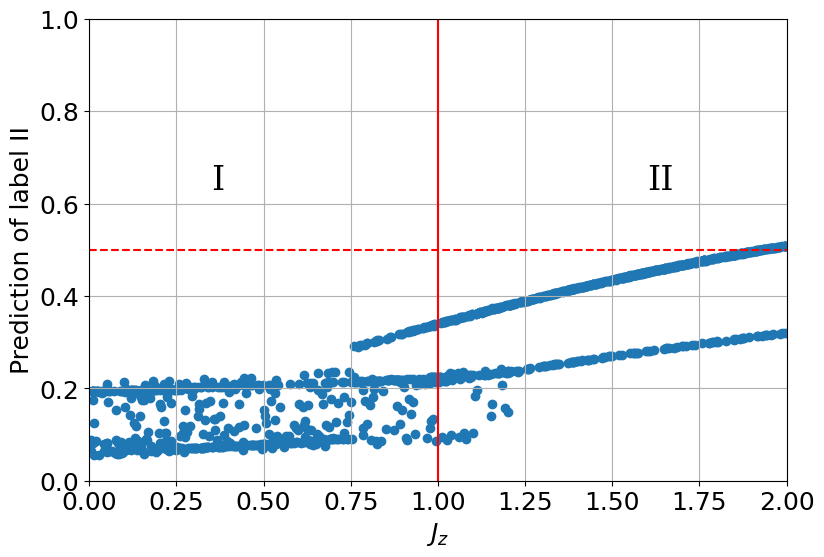

In [45]:
# %matplotlib inline
# plt.rcParams.update({'font.size': 14})
# plt.figure()
fields = np.array(df_test[n_max])
plt.scatter(fields, preds)

plt.xlabel(r'$J_z$')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 2])
plt.plot([1, 1], [0, 1], 'r')
plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
plt.plot([0, 2], [0.5, 0.5], 'r--')
plt.show()

In [46]:
correct = 0
for i, p in enumerate(preds):
    if abs(trues[i] - p) < 0.5:
        correct += 1
print(correct / len(df_test))

0.5033333333333333
